# **Pyvista** for 3D visualization of PIC simulation data
Here we present a demonstration of 3D visualazation of Wuming PIC simulation data. Although there are several ways of the 3D visualzation, including **ParaView** and **VisIt**, we recommend to use **PyVista** because of its usability with minimum installation of the additional libraries. **PyVista** is based on the **VTK** format, but it offers simple *pythonic* interfaces to the VTK libarary. For more details, refer to the official website: https://docs.pyvista.org/

## Installation
For instaling via pip,

```bash
$ pip install pyvista[all,trame] jupyterlab
```

For conda installation,

```bash
$ conda install -c conda-forge pyvista jupyterlab trame trame-vuetify trame-vtk ipywidgets
```

These installations enable interactive operations in the jupyter notebook or from the ipython console.

## Library import

In [1]:
import h5py
import numpy as np
import pyvista as pv

## Reading PIC simulation data
In this particular case, we draw magnetic field lines along with the electron density from a 3D magnetic reconnection run.

In [2]:
%%time
dat = h5py.File('./0004000_mom.h5','r')
f = h5py.File('init_param.h5','r')
params = dict(f.attrs)

n_subsample=2
ef = dat['uf'][::n_subsample,::n_subsample,::n_subsample,:] # EM fields with sub-sampling
den = dat['den'][1,::n_subsample,::n_subsample,::n_subsample] #electron number density with sub-sampling
print(den.shape) # (nz, ny, nx)

(384, 660, 161)
CPU times: user 40.3 s, sys: 5min 48s, total: 6min 29s
Wall time: 6min 43s


## Converting ndarray to pyvista's dataset
The simulation data array is in order of `(nz, ny, nx)` . It should be transposed to `(nx, ny, nz)`.

In [3]:
nxyz = den.T.shape
mesh = pv.ImageData(dimensions=(nxyz[0]+1, nxyz[1]+1, nxyz[2]+1))

Note that the simulation data is a cell-centered value. 

In [4]:
mesh.cell_data['|B|'] = np.sqrt(np.sum(np.square(ef[:,:,:,0:3]),axis=3)).T.reshape(-1,order='F')
mesh.cell_data['Number density'] = den.T.reshape(-1,order='F')
mesh.cell_data['mag_lines'] = ef[:,:,:,0:3].transpose(2,1,0,3).reshape((mesh.n_cells,3),order='F')

## Converting from cell data to grid data for `streamlines()`
Preparting point data for drawing the field lines, which is necessary for using `streamlines()`. `cell_data_to_point_data()` method calculates the value at nodes by taking an average of the neibouring cells.

In [5]:
mesh2 = mesh.cell_data_to_point_data()
_ = mesh2.point_data.pop('Number density')

Starting points to draw stream lines are on the surface of a sphere of radius `source_radius` located at `source_center` .

In [6]:
stream1 = mesh2.streamlines(vectors='mag_lines',n_points=170,source_radius=nxyz[2]/3,source_center=(nxyz[0]/2,0,nxyz[2]/2))
stream2 = mesh2.streamlines(vectors='mag_lines',n_points=170,source_radius=nxyz[2]/3,source_center=(nxyz[0]/2,nxyz[1]-1,nxyz[2]/2))
stream3 = mesh2.streamlines(vectors='mag_lines',n_points=170,source_radius=nxyz[2]/3,source_center=(nxyz[0]/2,nxyz[1]/2,nxyz[2]/2))

## Drawing
If you prefer to operate the 3D view interactively, set `jupyter_backend='trame'` instead.

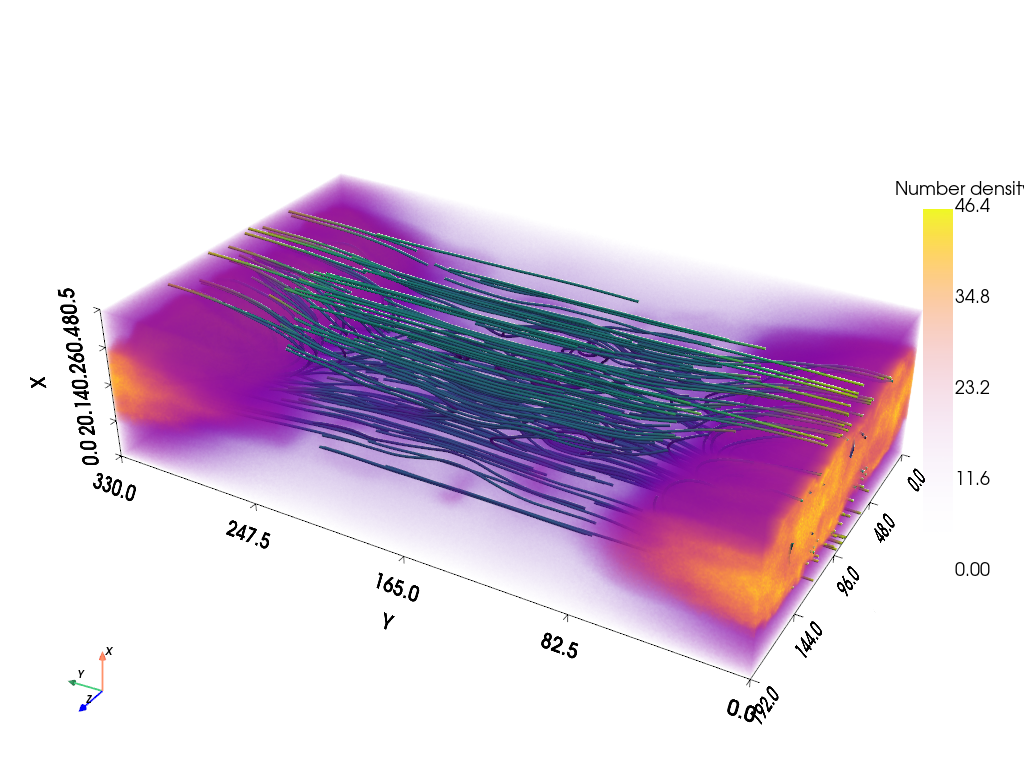

In [7]:
pl = pv.Plotter()
sargs = dict(height=0.5,vertical=True,position_x=0.9,position_y=0.25,interactive=False)
opac_table = np.linspace(0,1,100)**2.5

l0 = params['c']/params['wpe']
axes_ranges = [0,nxyz[0],0,nxyz[1],0,nxyz[2]]/l0*n_subsample

pl.add_mesh(stream1,scalars="|B|",render_lines_as_tubes=True,line_width=3,show_scalar_bar=False)
pl.add_mesh(stream2,scalars="|B|",render_lines_as_tubes=True,line_width=3,show_scalar_bar=False)
pl.add_mesh(stream3,scalars="|B|",render_lines_as_tubes=True,line_width=3,show_scalar_bar=False)
pl.add_volume(mesh,scalars="Number density",opacity=opac_table,cmap='plasma', scalar_bar_args=sargs)
pl.add_axes()
pl.show_bounds(axes_ranges=axes_ranges,xtitle='X',ytitle='Y',ztitle='Z',location='outer',font_size=16,ticks='outside')
pl.camera_position='xy'
pl.camera.roll+=90
pl.camera.azimuth+=30
pl.camera.elevation+=30
pl.camera.zoom(1.1)

pl.screenshot('reconnection3d.png')
pl.show(jupyter_backend= 'static') #disable interactive mode